In [3]:
import numpy as np
from DG_classes import *
from DiffusionGeometry import *
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from visualisation import *
import plotly.io as pio
pio.renderers.default = "svg"

Create some data

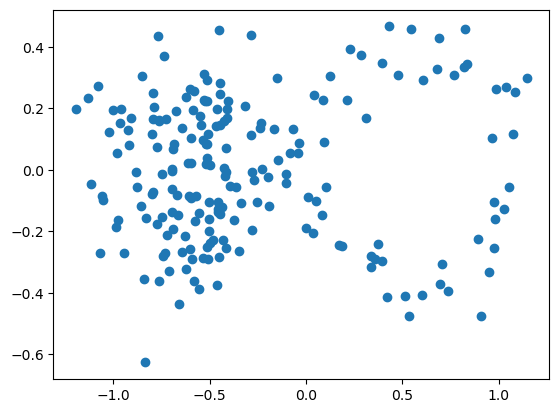

In [2]:
n = 100
xx = np.linspace(0, 2*np.pi, n)
data = np.array([[np.cos(x), np.sin(x)] for x in xx]) + 0.2*np.random.randn(xx.shape[0], 2)
data = 1*np.array([[np.cos(x)/(1 + np.sin(x)**2), np.sin(x)*np.cos(x)/(1 + np.sin(x)**2)] for x in xx]) + 0.06*np.random.randn(xx.shape[0], 2) + 0.1*data
data = np.concatenate((data, 0.2*np.random.randn(100,2) - [0.6,0]))

plt.scatter(data[:,0], data[:,1])

Set some parameters for DG. 
For 2d data like this, n2 = 4 is usually fine. n1 = 16 seems to work well. n0 can be anything and just sets the precision (setting n0 = 100 here is very high precision, and n0 = 30 would also do).

Let's compute at the spectrum of the Laplacian with diffusion maps.

First 12 eigenvalues of the Laplacian:
 [-0.   1.3  4.3  6.8  9.2 14.2 17.5 21.3 23.6 34.5 37.3 41.4]
Their corresponding eigenfunctions:


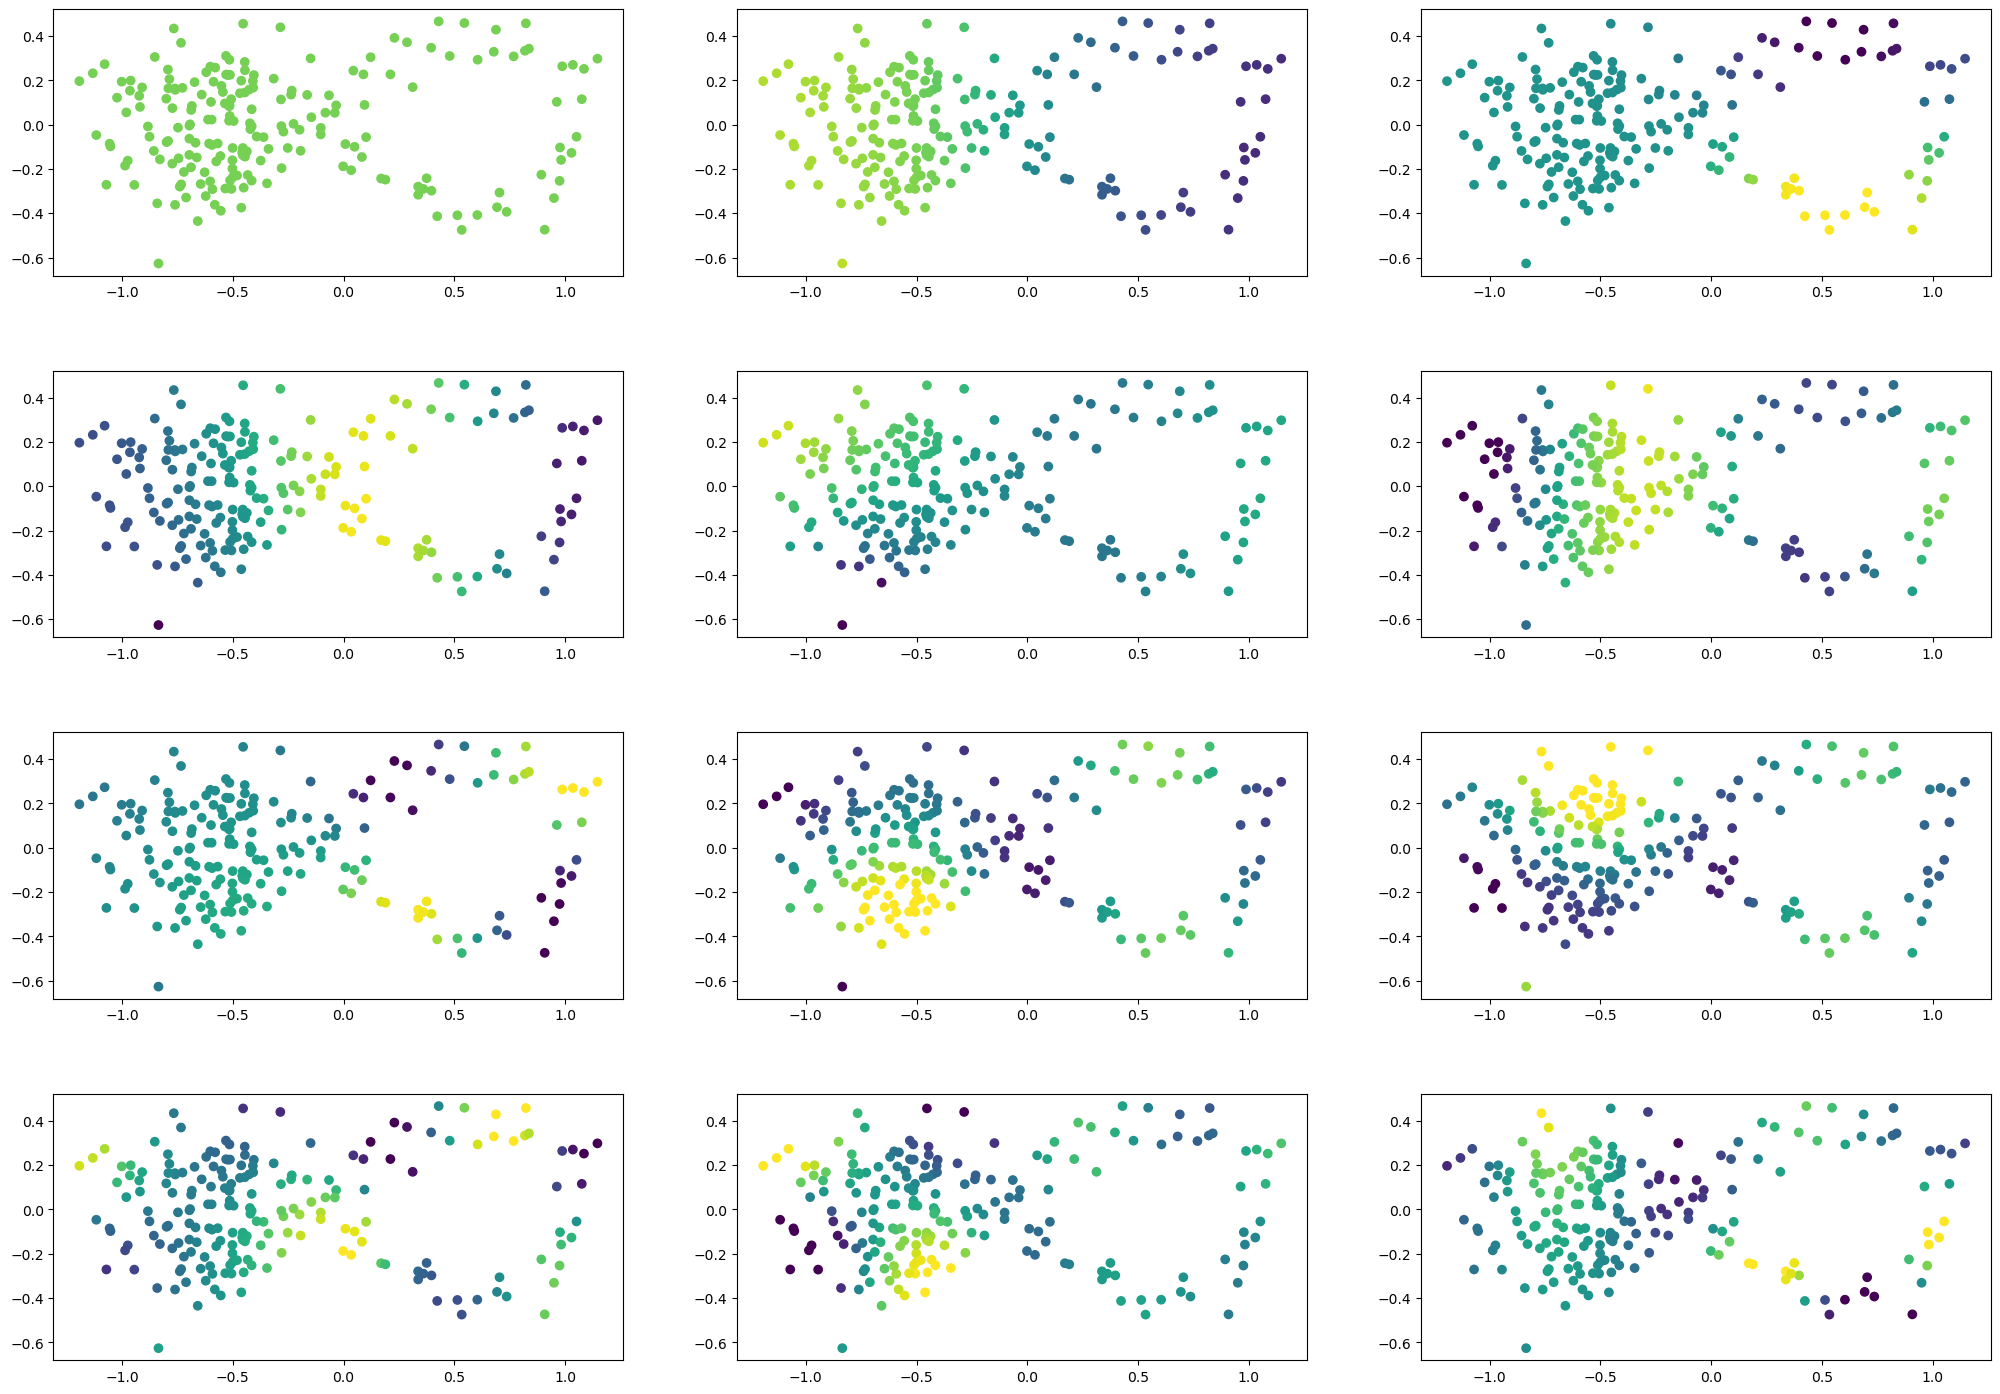

In [19]:
parameters = {}
parameters['n0'] = 100
parameters['n1'] = 16
parameters['n2'] = 4
parameters['ep'] = 0.1
parameters['alpha'] = 1
parameters['projection_tol'] = 1e-2

DG_data = DG(data, parameters)
print('First 12 eigenvalues of the Laplacian:\n', DG_data.lam()[:12].round(1))
print('Their corresponding eigenfunctions:')
DG_data.plot_eigenfunctions(4,3)

Let's now look at the spectrum of the Hodge Laplacian. The data has a large 'hole' which we expect to see as a harmonic 1-form.

In [20]:
vals_1, forms_1 = DG_data.weak_eigenproblem_1(DG_data.D1())

print('First 12 eigenvalues of the 1-Hodge Laplacian:\n', vals_1[:12].round(1))

print('It\'s first eigenform:')
a1 = forms_1[:,0]
plot_quiver_plain(a1, DG_data).show()

print('Second eigenform:')
a2 = forms_1[:,1]
plot_quiver_plain(a2, DG_data).show()

First 12 eigenvalues of the 1-Hodge Laplacian:
 [ 0.4  1.7  5.   6.8 13.9 18.  20.3 24.8 36.2 42.6 43.8 50.8]
It's first eigenform:


Second eigenform:


Let's plot some metrics, by (literal) contraction with the metric tensor. 
This will show use the supports of the forms, and where they align.

We are working in the eigenfunction basis for functions, so need to multiply by u.T to get back into the pointwise basis.

In [21]:
metric_a1a1 = contract('ijk,i,j', DG_data.g1(), a1, a1)
print('Metric g(a_1,a_1):')
plot_scatter(DG_data.data, DG_data.u().T @ metric_a1a1).show()

metric_a2a2 = contract('ijk,i,j', DG_data.g1(), a2, a2)
print('Metric g(a_2,a_2):')
plot_scatter(DG_data.data, DG_data.u().T @ metric_a2a2).show()

metric_a1a2 = contract('ijk,i,j', DG_data.g1(), a1, a2)
print('Metric g(a_1,a_2):')
plot_scatter(DG_data.data, DG_data.u().T @ metric_a1a2).show()

Metric g(a_1,a_1):


Metric g(a_2,a_2):


Metric g(a_1,a_2):


We can also wedge these two forms together to get a 2-form. The bivector field representaion is not unique (so is a slightly crude visualisation). Let's also look at its metric.

In [22]:
wedge_a1a2 = contract('ijk,i,j', DG_data.wedge_11(), a1, a2)

print('a_1 wedge a_2 as a bivector field:')
plot_2_form_plain(2*wedge_a1a2, DG_data).show()

norm_wedge_a1a2 = contract('ij,i,j', DG_data.G2(), wedge_a1a2, wedge_a1a2)**0.5
print('Norm of the wedge product:', norm_wedge_a1a2.round(3))

metric_wedge_a1a2 = contract('ijk,i,j', DG_data.g2(), wedge_a1a2, wedge_a1a2)
print('Metric g(a_1 a_2,a_1 a_2):')
plot_scatter(DG_data.data, DG_data.u().T @ metric_wedge_a1a2).show()

a_1 wedge a_2 as a bivector field:


Norm of the wedge product: 0.075
Metric g(a_1 a_2,a_1 a_2):


We see that this wedge product has small norm, because the forms are mainly supported on a '1-dimensional' part of the data where the 2-forms should be zero. The non-zero part is where the data becomes more 2d in the middle, which is measured by the metric.

1-forms have a Hodge decomposition, and we can project these 1-forms onto their 'exact' part. We first find the function f such that df is their exact part.

Eigenforms of the Hodge Lapacian should be entirely harmonic, df (for a function f) or d^*a (for a 2-form a). We can test this here.

In [30]:
a1_grad_function = DG_data.grad_decomp_matrix() @ a1
a2_grad_function = DG_data.grad_decomp_matrix() @ a2

a1_exact_part = DG_data.d0() @ a1_grad_function
a2_exact_part = DG_data.d0() @ a2_grad_function

norm_a1_exact_part = contract('ij,i,j', DG_data.G1(), a1_exact_part, a1_exact_part)**0.5
norm_a2_exact_part = contract('ij,i,j', DG_data.G1(), a2_exact_part, a2_exact_part)**0.5

print('Exact part of a_1 has norm', norm_a1_exact_part.round(3))
plot_quiver_plain(a1_exact_part, DG_data).show()

print('Exact part of a_2 has norm', norm_a2_exact_part.round(3))
plot_quiver_plain(a2_exact_part, DG_data).show()

Exact part of a_1 has norm 0.061


Exact part of a_2 has norm 0.997


a_1 is harmonic so has negligible a_1 part, whereas a_2 is entirely df for some f. We plot that f now, and verify that df = a_2.

In [63]:
print('Function f')
plot_scatter(DG_data.data, DG_data.u().T @ a2_grad_function).show()

diff = a2 - DG_data.d0() @ a2_grad_function
norm_diff = contract('ij,i,j', DG_data.G1(), diff, diff)**0.5
print('Difference between df and a_2 has norm', norm_diff.round(2))

Function f


Difference between df and a_2 has norm 0.04


We can interpret these 1-forms as their dual vector fields, and so can use them to differentiate functions. Let's differentiate different functions with respect to a_1.

In [60]:
n0 = DG_data.parameters['n0']

f = np.eye(n0)[6]
print('A function f')
plot_scatter(DG_data.data, DG_data.u().T @ f).show()

# Dualise a_1 and reshape it into a matrix to act on functions.
a1_operator = (DG_data.G1_VF() @ a1).reshape(n0,n0)

print('a1#(f)')
plot_scatter(DG_data.data, DG_data.u().T @ (a1_operator @ f)).show()

A function f


a1#(f)
